# Estimación de Tarjetas de Puntuación Corrigiendo el Sesgo de Selección Muestral

En esta aplicación implementaremos un modelo de puntuación de riesgo de impago aplicando inferencia de denegados. Aplicaremos el resto de la metodología de forma automática para simplificar el código(selección de variables mediante valor de la información, tramificación de variables continuas, agrupación de categorías, transformación woe de variables, estimación de modelos de regresión logística, ....)

Utilizaremos la librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/)  

## Creación de un entorno e instalación de librerías 



In [1]:
# Podemos Crear un nuevo entorno de trabajo (mejor desde el terminal)
#! conda create -n risk_env
#! conda activate risk_env
#! conda config --env --add channels conda-forge
#! conda config --env --set channel_priority strict

# Instalamos la librería pandas y seaborn en el nuevo entrono desde conda (sólo la primera vez, utilizaré el terminal (con jupiter debo utilizar !))
# conda install pandas
# conda install seaborn

# Instalamos la librería optbinning y scorecardpy (sólo la primera vez)
# ! pip install scorecardpy
# ! pip install optbinning


#Cargo o importo pandas, numpy, Matplotlib, 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para el análisis descriptivo inicial de contraste de asociación importo el test Chi2 y el anova 
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# Cargaríamos la librería scortecardpy si fuese estable (que no lo es)
#import scorecardpy as sc


# Librería para hacer la tramificación, agrupación y transformación WOE
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks


# Scikit-learn para dividir la muestra y para estimar el modelo de regresión logística (sólo si no se quiere utilizar
# la función optbinning.scorecard que ya lo incropora)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

(CVXPY) Feb 09 10:52:13 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 09 10:52:13 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


# Preparación de los datos sobre Créditos que utilizaremos en la práctica **germancredit**
## Carga de los datos 
En nuestra práctica utilizaremos una de las bases más utilizadas en los ejemplos de Puntuación de riesgo de crédito porque fue una de las primeras en ofrecerse en abierto. Corresponden a una base de datos de créditos de un Banco Alemán, y son datos reales, aunque muy antigüos de principios de los 90. Eso significa que las magnitudes de cantidades (expresadas en Marcos Alemanes), sean de difícil interpretación para el día de hoy. Sin embargo el signo y el sentido de las variables utilizadas para predecir el riesgo de impago de los futuros clientes permanece todavía de plena utilidad.

Los datos pueden descargarse del repositorio la UCI Machine Learning Repositoy [datos de Créditos alemanes](https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)). Esta base de datos está incorporada en la librería `sorecardpy` pero mejor utilizamos el fichero original `germancredit.csv` que os he preparado yo

Yo he modificado estos datos para crear un conjunto de datos de clientes Aceptados, un conjunto de datos de Rechazados y conjunto de datos de Nuevos Clientes que hay que puntuar

In [2]:
# Cargamos los datos germancredit que están precargados en la librería scorecardpy
dt=pd.read_csv('Aceptados.csv')
Rechazados=pd.read_csv('Rechazados.csv')
Nuevos=pd.read_csv('Nuevos.csv')

## Descripción inicial de los datos
Vamos a hacer una descripción inicial de los datos


In [3]:
#Información del Contenido
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   status.of.existing.checking.account                       955 non-null    object
 1   duration.in.month                                         955 non-null    int64 
 2   credit.history                                            955 non-null    object
 3   purpose                                                   955 non-null    object
 4   credit.amount                                             955 non-null    int64 
 5   savings.account.and.bonds                                 955 non-null    object
 6   present.employment.since                                  955 non-null    object
 7   installment.rate.in.percentage.of.disposable.income       955 non-null    int64 
 8   personal.status.and.sex       

La **variable objetivo** será `y` que es la variable impago (y=1). 


In [4]:
dt['y'].value_counts()

0    668
1    287
Name: y, dtype: int64

In [5]:
dt['y'].value_counts(normalize=True)

0    0.699476
1    0.300524
Name: y, dtype: float64

Las 20 restantes variables (7 numéricas y 13 categóricas) son los atributos o características observadas de esos clientes que se utilizarán para predecir la probabilidad de que los clientes cometan un impago de sis créditos, esto es, de que sean malos clientes. La descripción de estas 20 variables es la siguiente:

In [6]:
#  - Attribute 1: (qualitative) **Status of existing checking account o cuenta corriente** 
#   - A11 : ... < 0 DM 
#   - A12 : 0 <= ... < 200 DM 
#   - A13 : ... >= 200 DM / salary assignments for at least 1 year 
#   - A14 : no checking account 

#- Attribute 2: (numerical) **Duration in month** 
  
#  - Attribute 3: (qualitative) **Credit history**  
#     - A30 : no credits taken/ all credits paid back duly (devultos sin mora)
#     - A31 : all credits at this bank paid back duly 
#     - A32 : existing credits paid back duly till now 
#     - A33 : delay in paying off in the past 
#     - A34 : critical account/ other credits existing (not at this bank) 

# - Attribute 4: (qualitative) **Purpose** 
#     - A40 : car (new) 
#     - A41 : car (used)
#     - A42 : furniture/equipment
#     - A43 : radio/television
#     - A44 : domestic appliances
#     - A45 : repairs
#     - A46 : education
#     - A47 : (vacation - does not exist?)
#     - A48 : retraining
#     - A49 : business
#    - A410 : others 

# - Attribute 5: (numerical) **Credit amount** 
  
# - Attribute 6: (qualitative) **Savings account/bonds** 
#    - A61 : ... < 100 DM
#    - A62 : 100 <= ... < 500 DM
#    - A63 : 500 <= ... < 1000 DM
#    - A64 : .. >= 1000 DM 
#    - A65 : unknown/ no savings account 

# - Attribute 7: (qualitative) **Present employment since** 
#     - A71 : unemployed 
#     - A72 : ... < 1 year 
#     - A73 : 1 <= ... < 4 years 
#     - A74 : 4 <= ... < 7 years 
#     - A75 : .. >= 7 years 

# - Attribute 8: (numerical) **Installment rate in percentage of disposable income** 
  
#  - Attribute 9: (qualitative) **Personal status and sex** 
#     - A91 : male : divorced/separated
#     - A92 : female : divorced/separated/married
#     - A93 : male : single
#     - A94 : male : married/widowed
#     - A95 : female : single 

# - Attribute 10: (qualitative) **Other debtors / guarantors**
#    - A101 : none
#    - A102 : co-applicant
#    - A103 : guarantor 

# - Attribute 11: (numerical) **Present residence since**
  
# - Attribute 12: (qualitative) **Property**
#     - A121 : real estate
#     - A122 : if not A121 : building society savings agreement/ life insurance
#     - A123 : if not A121/A122 : car or other, not in attribute 6 
#     - A124 : unknown / no property 

# - Attribute 13: (numerical) **Age in years** 
  
# - Attribute 14: (qualitative) **Other installment plans** Otros pagos por plazos
#      - A141 : bank
#      - A142 : stores
#      - A143 : none 

# - Attribute 15: (qualitative) **Housing**
#      - A151 : rent 
#      - A152 : own
#      - A153 : for free 

# - Attribute 16: (numerical) **Number of existing credits at this bank**
  
# - Attribute 17: (qualitative) **Job**
#   - A171 : unemployed/ unskilled - non-resident
#   - A172 : unskilled - resident
#   - A173 : skilled employee / official
#   - A174 : management/ self-employed/highly qualified employee/ officer 

# - Attribute 18: (numerical) **Number of people being liable to provide maintenance for** 
  
# - Attribute 19: (qualitative) **Telephone**
#   - A191 : none
#   - A192 : yes, registered under the customers name 

# - Attribute 20: (qualitative) **foreign worker** 
#   - A201 : yes 
#   - A202 : no 


# Primera Etapa: Construcción del primer modelo sólo con los Aceptados

### Dividimos la muestra en entrenamiento y test

In [7]:
dt_train, dt_test = train_test_split(dt,stratify=dt["y"], test_size=.25, random_state=1234)

In [8]:
dt_train["y"].mean()

0.30027932960893855

In [9]:
dt_test["y"].mean()

0.301255230125523

### Defino la tramificación óptima

In [10]:
# 1) Definimos la lista de nombres señalando cuales de ellas son las categóricas
Y = dt_train['y'].values
X = dt_train.drop(columns=['y']) #todas menos la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

In [11]:
# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02, "max": 1}
}

In [12]:
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

In [13]:
# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

In [14]:
# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

In [15]:
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
19,foreign.worker,categorical,OPTIMAL,False,1,0.0,0.0,0,0.0
18,telephone,categorical,OPTIMAL,False,2,0.001424,0.000178,0.018484,0.001355
17,number.of.people.being.liable.to.provide.maint...,numerical,OPTIMAL,False,2,0.002364,0.000295,0.017491,0.001543
10,present.residence.since,numerical,OPTIMAL,False,4,0.004856,0.000607,0.037386,0.000284
9,other.debtors.or.guarantors,categorical,OPTIMAL,False,2,0.015245,0.001881,0.025326,0.006828
8,personal.status.and.sex,categorical,OPTIMAL,False,4,0.018887,0.002342,0.054301,0.006319
15,number.of.existing.credits.at.this.bank,numerical,OPTIMAL,True,2,0.027413,0.003421,0.079608,0.068493
7,installment.rate.in.percentage.of.disposable.i...,numerical,OPTIMAL,True,4,0.030183,0.003767,0.092466,0.006085
16,job,categorical,OPTIMAL,True,3,0.035195,0.00437,0.075579,0.024103
13,other.installment.plans,categorical,OPTIMAL,True,2,0.065659,0.008131,0.100803,0.104211


# Estimación del Modelo

Ahora podemos calcular la tarjeta de puntuación. En los apuntes de clase definimos tanto los WOE, como los Odd ratio como la probabilidad de `evento` respecto al `no-evento` (malos clientes o impago=1 respecto a los buenos clientes o impago=0):

$$ odd = {{P}\over {(1-P)}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$
 
 Y la fórmula para obtener la puntuación o los score debe ser una relación negativa con los odd ratio: cuanto mayor la probabilidad de impago (en relación a la de no impago), menor puntuación ha de tener: 

 $$ score {= offset - Factor}~·~{ln(odds)}$$

 para obtener los valores concretos de esta recta que transforma probabilidades a puntos (para conocer el valor de $offset$ y de $Factor$), hay que decidir de manera arbitraria una pendiente y un punto de la anterior recta. Para la pendiente suele establecerse cada cuántos puntos de score (**pdo_0**) que dobla el odd ratio: $ score - pdo_0 = {offset -Factor}~ ·{ln(2*odds)}$. Mientras que para establecer un punto de la recta se establece una puntuación o score arbitraria que se considere que debería tener un cliente con una calidad credicitica de *sobresaliente* (**scorecard_points**), y también el odd ratio que debería tener ese cliente de *sobresaliente* (**odds_0**). Así habría que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40
* **scorecard_points** =600 
* **odds_0** =1/50

La librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/), en realidad utiliza el módulo de `credit scoring` de `SAS-miner` como inspiración, y por eso define al revés tanto los WOE como los odd ratio, es decir `no-evento` en relación a `evento` (clientes buenos respecto a los malos, o no-impago respecto a impago, impago=0 respecto a impago=1). 
$$ odd^B = {{(1-P)}\over {P}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$

Esto implica que la ecuación que transforma las probabilidades de impago en scores utilizando esta *odds<sup>B</sup>* debe tener pendiente positiva (cuanto mejor *odd<sup>B</sup>* mejor calidad crediticia tiene el cliente)

 $$ score= {offset + Factor} ~·~ {ln(odds^B)}$$
 
 Nótese que ahora habrá que establecer de nuevo los puntos de score que doblan el odd ratio (**pdo_0**), y también la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* **odds_0 <sup>*B*</sup>**, con **odds_0 <sup>*B*</sup>** **= 1/odds_0**.

 Así para estimar la puntuación crediticia con `optBinning` hay que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40
* **scorecard_points** =600 
* **odds_0 <sup>*B*</sup>** = 50  (equivalente a **odds_0** =1/50 )




In [16]:

# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         categorical_variables=['status.of.existing.checking.account',
                                                                'credit.history',
                                                                'purpose',
                                                                'savings.account.and.bonds',
                                                                'present.employment.since',
                                                                'personal.status.and.sex',
                                                                'other.debtors.or.guarantors',
                                                                'property',
                                                                'other.installment.plans',
                                                                'housing',
                                                                'job',
                                                                'teleph...
                                                         'other.debtors.or.guarantors',
                                                         'present.residence.since',
                                                         'property',
                                                         'age.in.years',
                                                         'other.installment.plans',
                                                         'housing',
                                                         'number.of.existing.credits.at.this.bank',
                                                         'job',
                                                         'number.of.people.being.liable.to.provide.maintenance.for',
                                                         'telephone',
                                                         'foreign.worker']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [17]:
tarjeta.information(print_level=2)

optbinning (Version 0.17.2)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                  pdo_odds   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                    716
    Number of variables                   20
    Target type                       binary

    Number of numerical                    7
    Number of categorical                 13
    Number of selected                    14

  Timing
    Total time                          1.57 sec
    Binning process                     1.44 sec   ( 91.45%)
    Estimator                           0.02 sec   (  1.39%

In [18]:
tarjeta.table(style="detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,status.of.existing.checking.account,0,[no checking account],292,0.407821,252,40,0.136986,0.994582,0.315230,0.037856,-0.738534,72.578849
1,status.of.existing.checking.account,1,[... >= 200 DM / salary assignments for at lea...,44,0.061453,32,12,0.272727,0.134861,0.001087,0.000136,-0.738534,35.938288
2,status.of.existing.checking.account,2,[0 <= ... < 200 DM],187,0.261173,115,72,0.385027,-0.377702,0.039788,0.004944,-0.738534,14.093272
3,status.of.existing.checking.account,3,[... < 0 DM],193,0.269553,102,91,0.471503,-0.731855,0.160761,0.019658,-0.738534,-1.000419
4,status.of.existing.checking.account,4,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.738534,30.190617
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,job,0,[unskilled - resident],143,0.199721,104,39,0.272727,0.134861,0.003532,0.000441,-0.450771,33.698763
1,job,1,"[unemployed/ unskilled - non-resident, skilled...",473,0.660615,337,136,0.287526,0.061460,0.002464,0.000308,-0.450771,31.789376
2,job,2,[management/ self-employed/ highly qualified e...,100,0.139665,60,40,0.400000,-0.440503,0.029199,0.003621,-0.450771,18.731809
3,job,3,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.450771,30.190617


In [19]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)


0.30028

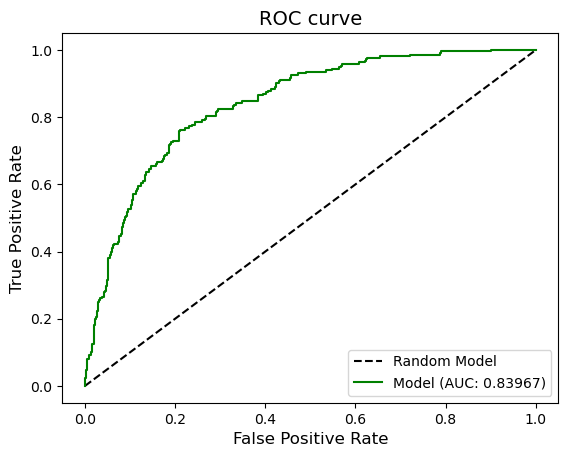

In [20]:
# Diagnosis Curva ROC
plot_auc_roc(Y,Y_pred)

In [21]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test = dt_test['y'].values
X_test = dt_test.drop(columns=['y']) #todas menos la primera que es el ID y la variable y

Y_test_pred=tarjeta.predict_proba(X_test)[:,1]


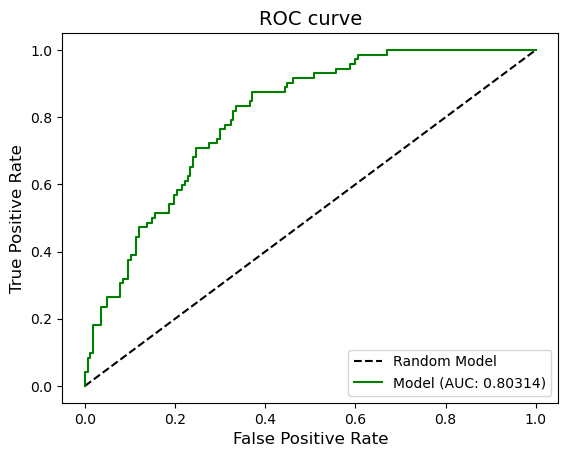

In [22]:
# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)


# Realizamos la inferencia de Rechazados

In [23]:
# primero estimo el punto de corte utilizando el valor medio (calculo su f1-score)
Prob_Corte=Y.mean()
f1_score(Y,Y_pred>Y_pred.mean())

0.6640471512770137

In [24]:
# Hacemos la inferencia
X_rechazados = Rechazados.drop(columns=['y']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_rechazados_pred=tarjeta.predict_proba(X_rechazados)[:,1]
Rechazados["y"]=np.multiply(Y_rechazados_pred>Prob_Corte,1)


In [25]:
# Hago también una primera estimazión de la puntuación de los nuevos clientes para ver si hay diferencias con y sin rechazados
X_Nuevos = Nuevos.drop(columns=['y']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_Nuevos_pred=tarjeta.predict_proba(X_Nuevos)[:,1]
Nuevos["y_Sinrechazados"]=np.multiply(Y_Nuevos_pred>Prob_Corte,1)


# Anexamos los datos de los Rechazados inferidos a los Aceptados

In [26]:
dt=pd.concat([dt,Rechazados], axis=0)

In [27]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1124 entries, 0 to 168
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   status.of.existing.checking.account                       1124 non-null   object
 1   duration.in.month                                         1124 non-null   int64 
 2   credit.history                                            1124 non-null   object
 3   purpose                                                   1124 non-null   object
 4   credit.amount                                             1124 non-null   int64 
 5   savings.account.and.bonds                                 1124 non-null   object
 6   present.employment.since                                  1124 non-null   object
 7   installment.rate.in.percentage.of.disposable.income       1124 non-null   int64 
 8   personal.status.and.sex      

In [28]:
dt['y'].value_counts()

0    747
1    377
Name: y, dtype: int64

In [29]:
dt['y'].value_counts(normalize=True)

0    0.664591
1    0.335409
Name: y, dtype: float64

fíjate que ha aumentado el porcentaje de impagados, porque hemos incluido a los rechazados, que eran potencialmente malos

# Reestimo el modelo con todos, Aceptados y rechazados

In [30]:
### Dividimos la muestra en entrenamiento y test
dt_train, dt_test = train_test_split(dt,stratify=dt["y"], test_size=.25, random_state=1234)
dt_train["y"].mean()
dt_test["y"].mean()
### Defino la tramificación óptima

# 1) Definimos la lista de nombres señalando cuales de ellas son las categóricas
Y = dt_train['y'].values
X = dt_train.drop(columns=['y']) #todas menos la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02, "max": 1}
}
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
19,foreign.worker,categorical,OPTIMAL,False,1,0.0,0.0,0,0.0
17,number.of.people.being.liable.to.provide.maint...,numerical,OPTIMAL,False,2,0.00009,0.000011,0.003414,0.000013
10,present.residence.since,numerical,OPTIMAL,False,2,0.001783,0.000223,0.013712,0.000922
9,other.debtors.or.guarantors,categorical,OPTIMAL,False,2,0.003414,0.000426,0.012992,0.00111
18,telephone,categorical,OPTIMAL,False,2,0.008523,0.001065,0.045009,0.01797
15,number.of.existing.credits.at.this.bank,numerical,OPTIMAL,False,2,0.009969,0.001246,0.048467,0.021769
8,personal.status.and.sex,categorical,OPTIMAL,False,3,0.012541,0.001566,0.05696,0.014115
16,job,categorical,OPTIMAL,True,3,0.020094,0.002505,0.067882,0.031912
7,installment.rate.in.percentage.of.disposable.i...,numerical,OPTIMAL,True,3,0.049607,0.006187,0.11474,0.048323
13,other.installment.plans,categorical,OPTIMAL,True,2,0.075941,0.009395,0.109736,0.124901


In [31]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)

0.30836

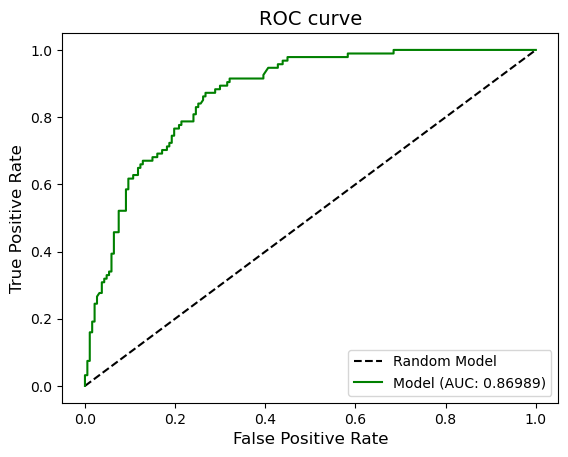

In [32]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test = dt_test['y'].values
X_test = dt_test.drop(columns=['y']) #todas menos la primera que es el ID y la variable y

Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)


# Puntuación de los nuevos cliente

In [33]:
# primero estimo el punto de corte utilizando el valor medio (calculo su f1-score)
Prob_Corte=Y.mean()
print(Prob_Corte)
f1_score(Y,Y_pred>Y_pred.mean())
# Hacemos la inferencia

X_Nuevos = Nuevos.drop(columns=['y']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_Nuevos_pred=tarjeta.predict_proba(X_Nuevos)[:,1]
Nuevos["y_Conrechazados"]=np.multiply(Y_Nuevos_pred>Prob_Corte,1)


0.33570581257413995
